# Coffee Futures - Data Analysis

Exploratory analysis of coffee commodity data for risk management.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

## 1. Load Data

In [2]:
import sys
sys.path.append('..')

from src.data_loader import get_coffee_futures, load_csv
import os

data_path = '../data/coffee_futures.csv'

if os.path.exists(data_path):
    df = load_csv(data_path)
    print("Loaded from CSV")
else:
    df = get_coffee_futures(save_path=data_path)
    print("Downloaded fresh data")

print(f"Shape: {df.shape}")
print(f"Date range: {df.index[0]} to {df.index[-1]}")
df.head()

Loaded from CSV
Shape: (1516, 9)
Date range: 2020-01-02 00:00:00 to 2026-01-08 00:00:00


,Close,High,Low,Open,Volume,returns,log_returns,volatility_20d,volatility_60d
Date,,,,,,,,,
2020-01-02,127.099998,130.949997,126.500000,129.550003,21506,NaN,NaN,NaN,NaN
2020-01-03,126.349998,128.449997,125.449997,127.199997,16566,-0.005901,-0.005918,NaN,NaN
2020-01-06,122.150002,126.550003,121.550003,126.250000,24428,-0.033241,-0.033806,NaN,NaN
2020-01-07,122.400002,123.400002,119.849998,122.599998,21308,0.002047,0.002045,NaN,NaN
2020-01-08,119.150002,123.050003,118.250000,122.500000,23061,-0.026552,-0.026911,NaN,NaN


## 2. Price Analysis

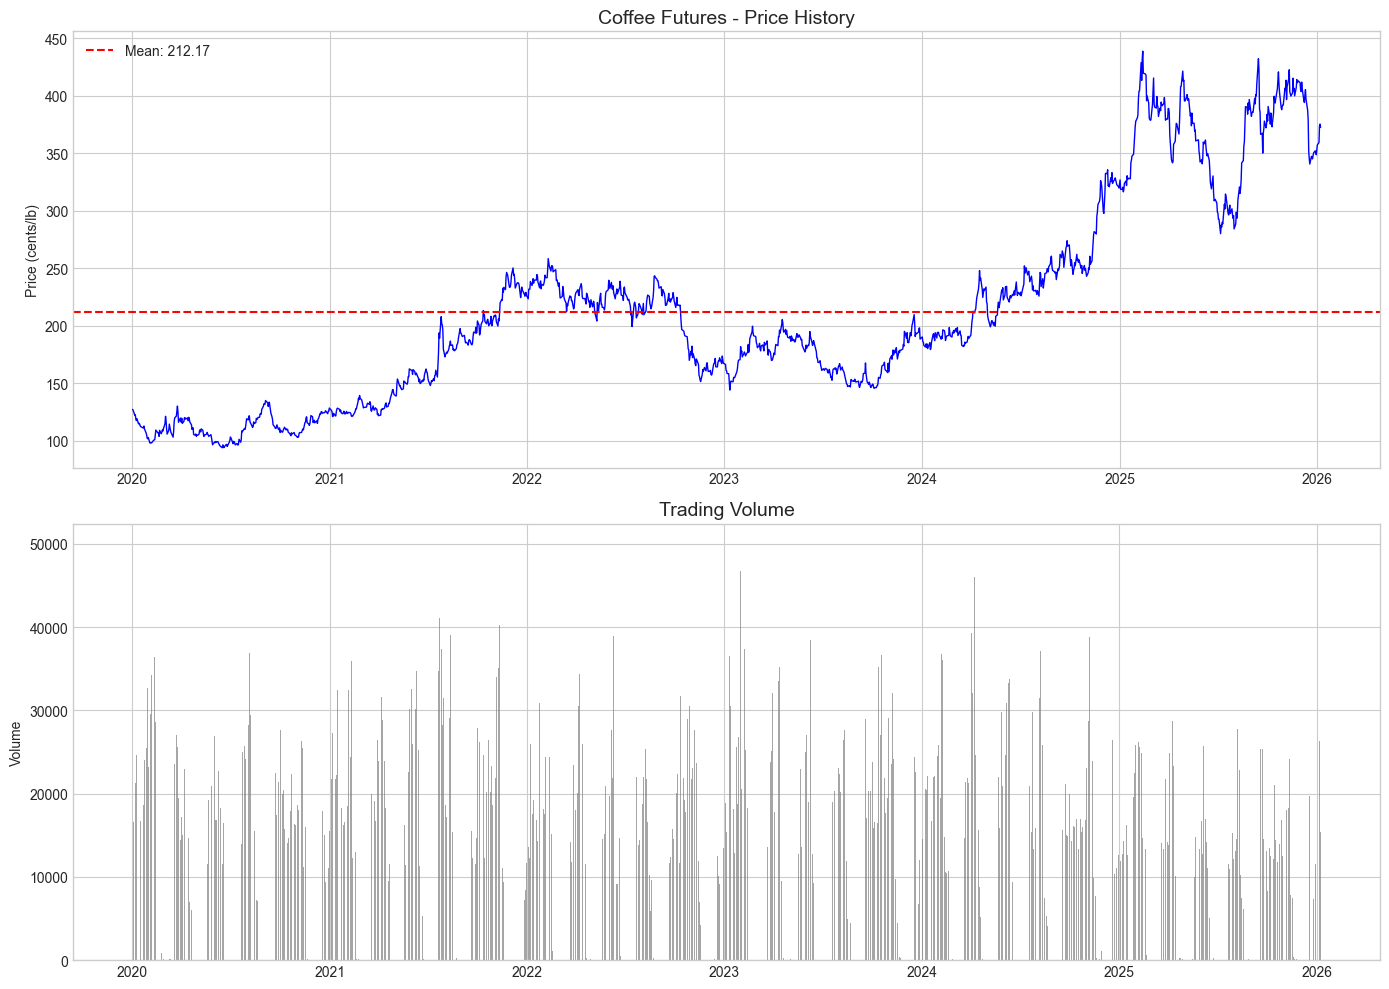

In [3]:
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# price chart
axes[0].plot(df.index, df['Close'], 'b-', linewidth=1)
axes[0].set_title('Coffee Futures - Price History', fontsize=14)
axes[0].set_ylabel('Price (cents/lb)')
axes[0].axhline(df['Close'].mean(), color='red', linestyle='--', label=f"Mean: {df['Close'].mean():.2f}")
axes[0].legend()

# volume
axes[1].bar(df.index, df['Volume'], color='gray', alpha=0.7)
axes[1].set_title('Trading Volume', fontsize=14)
axes[1].set_ylabel('Volume')

plt.tight_layout()
plt.savefig('../outputs/price_history.png', dpi=150)
plt.show()

In [4]:
# summary stats
print("=" * 50)
print("PRICE STATISTICS")
print("=" * 50)

stats_dict = {
    'Current Price': df['Close'].iloc[-1],
    'Mean': df['Close'].mean(),
    'Median': df['Close'].median(),
    'Std Dev': df['Close'].std(),
    'Min': df['Close'].min(),
    'Max': df['Close'].max(),
    '52W High': df['Close'].iloc[-252:].max() if len(df) > 252 else df['Close'].max(),
    '52W Low': df['Close'].iloc[-252:].min() if len(df) > 252 else df['Close'].min()
}

for k, v in stats_dict.items():
    print(f"{k:15s}: {v:>10.2f}")

PRICE STATISTICS
Current Price  :     372.65
Mean           :     212.17
Median         :     193.65
Std Dev        :      85.93
Min            :      93.65
Max            :     438.90
52W High       :     438.90
52W Low        :     280.05


## 3. Returns Analysis

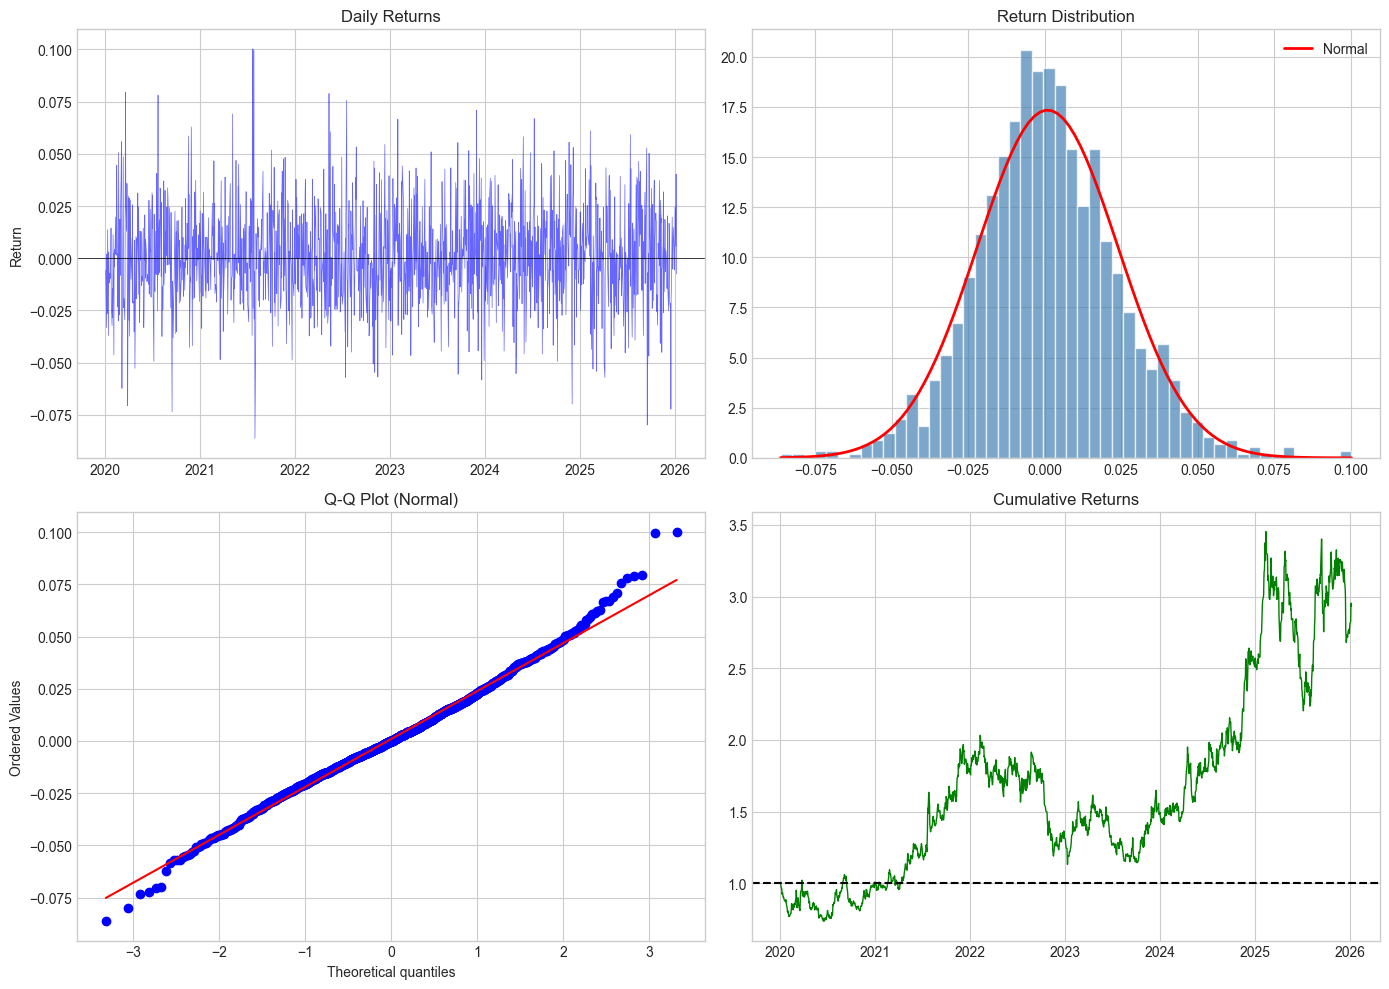

In [5]:
returns = df['returns'].dropna()

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# returns time series
axes[0, 0].plot(returns.index, returns, 'b-', alpha=0.6, linewidth=0.5)
axes[0, 0].axhline(0, color='black', linewidth=0.5)
axes[0, 0].set_title('Daily Returns')
axes[0, 0].set_ylabel('Return')

# histogram
axes[0, 1].hist(returns, bins=50, density=True, alpha=0.7, color='steelblue', edgecolor='white')
x = np.linspace(returns.min(), returns.max(), 100)
axes[0, 1].plot(x, stats.norm.pdf(x, returns.mean(), returns.std()), 'r-', linewidth=2, label='Normal')
axes[0, 1].set_title('Return Distribution')
axes[0, 1].legend()

# qq plot
stats.probplot(returns, dist='norm', plot=axes[1, 0])
axes[1, 0].set_title('Q-Q Plot (Normal)')

# cumulative returns
cum_returns = (1 + returns).cumprod()
axes[1, 1].plot(cum_returns.index, cum_returns, 'g-', linewidth=1)
axes[1, 1].set_title('Cumulative Returns')
axes[1, 1].axhline(1, color='black', linestyle='--')

plt.tight_layout()
plt.savefig('../outputs/returns_analysis.png', dpi=150)
plt.show()

In [6]:
print("=" * 50)
print("RETURNS STATISTICS")
print("=" * 50)

# annualization factor
annual = 252

return_stats = {
    'Daily Mean': returns.mean(),
    'Daily Std': returns.std(),
    'Annualized Return': returns.mean() * annual,
    'Annualized Vol': returns.std() * np.sqrt(annual),
    'Skewness': returns.skew(),
    'Kurtosis': returns.kurtosis(),
    'Min Daily': returns.min(),
    'Max Daily': returns.max(),
    'Sharpe (rf=2%)': (returns.mean() * annual - 0.02) / (returns.std() * np.sqrt(annual))
}

for k, v in return_stats.items():
    print(f"{k:20s}: {v:>10.4f}")

RETURNS STATISTICS
Daily Mean          :     0.0010
Daily Std           :     0.0230
Annualized Return   :     0.2455
Annualized Vol      :     0.3652
Skewness            :     0.1769
Kurtosis            :     0.8148
Min Daily           :    -0.0863
Max Daily           :     0.1003
Sharpe (rf=2%)      :     0.6173


## 4. Volatility Analysis

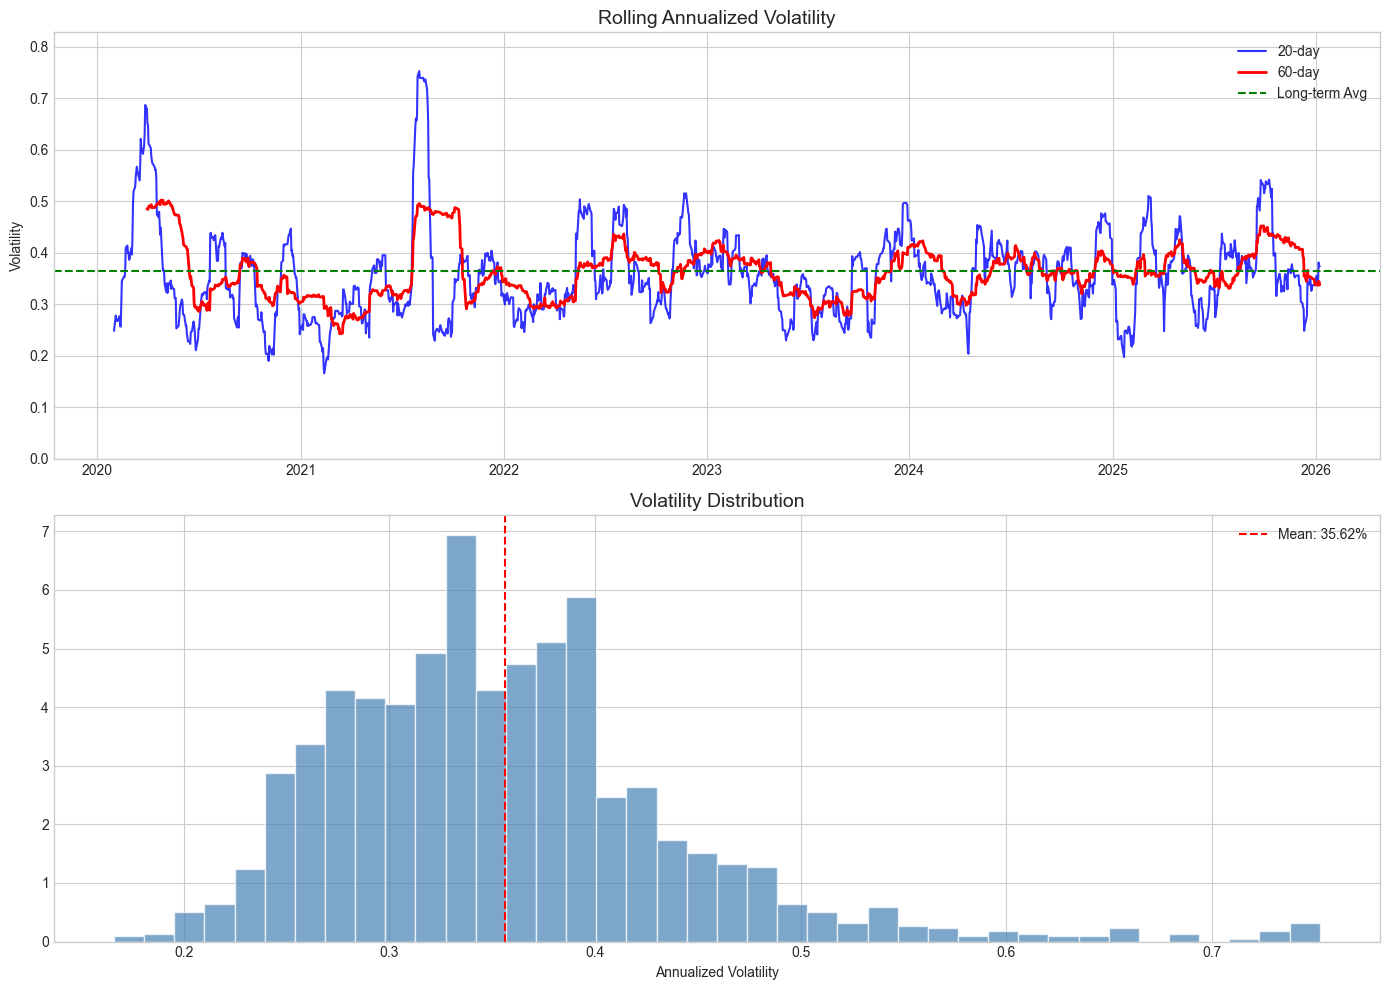

In [7]:
# rolling volatility
vol_20 = returns.rolling(20).std() * np.sqrt(252)
vol_60 = returns.rolling(60).std() * np.sqrt(252)

fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# volatility over time
axes[0].plot(vol_20.index, vol_20, 'b-', label='20-day', alpha=0.8)
axes[0].plot(vol_60.index, vol_60, 'r-', label='60-day', linewidth=2)
axes[0].axhline(returns.std() * np.sqrt(252), color='green', linestyle='--', label='Long-term Avg')
axes[0].set_title('Rolling Annualized Volatility', fontsize=14)
axes[0].set_ylabel('Volatility')
axes[0].legend()
axes[0].set_ylim(0, vol_20.max() * 1.1)

# volatility distribution
axes[1].hist(vol_20.dropna(), bins=40, density=True, alpha=0.7, color='steelblue', edgecolor='white')
axes[1].axvline(vol_20.mean(), color='red', linestyle='--', label=f"Mean: {vol_20.mean():.2%}")
axes[1].set_title('Volatility Distribution', fontsize=14)
axes[1].set_xlabel('Annualized Volatility')
axes[1].legend()

plt.tight_layout()
plt.savefig('../outputs/volatility_analysis.png', dpi=150)
plt.show()

In [8]:
print("=" * 50)
print("VOLATILITY SUMMARY")
print("=" * 50)

vol_stats = {
    'Current 20d Vol': vol_20.iloc[-1],
    'Current 60d Vol': vol_60.iloc[-1],
    'Average 20d Vol': vol_20.mean(),
    'Max 20d Vol': vol_20.max(),
    'Min 20d Vol': vol_20.min(),
    'Vol of Vol': vol_20.std()
}

for k, v in vol_stats.items():
    print(f"{k:20s}: {v:>10.2%}")

VOLATILITY SUMMARY
Current 20d Vol     :     37.38%
Current 60d Vol     :     33.76%
Average 20d Vol     :     35.62%
Max 20d Vol         :     75.24%
Min 20d Vol         :     16.61%
Vol of Vol          :      8.55%


## 5. Tail Risk Analysis

In [9]:
# extreme moves
threshold = 2  # std deviations
mean_ret = returns.mean()
std_ret = returns.std()

extreme_down = returns[returns < mean_ret - threshold * std_ret]
extreme_up = returns[returns > mean_ret + threshold * std_ret]

print("=" * 50)
print(f"EXTREME MOVES (> {threshold} std dev)")
print("=" * 50)
print(f"\nDays with extreme losses: {len(extreme_down)} ({len(extreme_down)/len(returns)*100:.1f}%)")
print(f"Days with extreme gains:  {len(extreme_up)} ({len(extreme_up)/len(returns)*100:.1f}%)")
print(f"\nExpected under normal: {(1-0.9545)*100:.2f}% each tail")

print("\n5 Worst Days:")
print(returns.nsmallest(5).to_string())

print("\n5 Best Days:")
print(returns.nlargest(5).to_string())

EXTREME MOVES (> 2 std dev)

Days with extreme losses: 35 (2.3%)
Days with extreme gains:  39 (2.6%)

Expected under normal: 4.55% each tail

5 Worst Days:
Date
2021-07-30   -0.086260
2025-09-17   -0.079811
2020-09-14   -0.073491
2025-12-17   -0.072238
2020-03-27   -0.070598

5 Best Days:
Date
2021-07-22    0.100284
2021-07-26    0.099471
2020-03-19    0.079593
2022-05-11    0.078922
2020-07-22    0.078109


In [10]:
# tail percentiles
percentiles = [1, 2.5, 5, 10, 90, 95, 97.5, 99]

print("\nReturn Percentiles:")
print("-" * 30)
for p in percentiles:
    val = np.percentile(returns, p)
    print(f"{p:5.1f}%: {val:>10.4f}")


Return Percentiles:
------------------------------
  1.0%:    -0.0530
  2.5%:    -0.0444
  5.0%:    -0.0355
 10.0%:    -0.0264
 90.0%:     0.0303
 95.0%:     0.0396
 97.5%:     0.0473
 99.0%:     0.0592


## 6. Seasonality Check

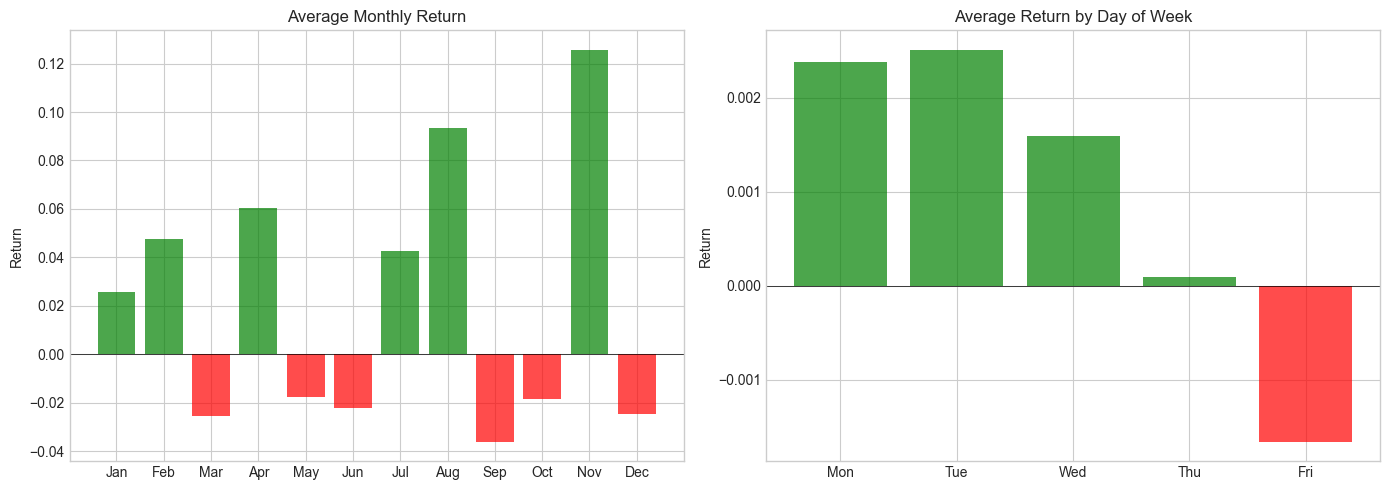

In [11]:
# monthly patterns
df_temp = df.copy()
df_temp['month'] = df_temp.index.month
df_temp['weekday'] = df_temp.index.dayofweek

monthly_returns = df_temp.groupby('month')['returns'].mean() * 21  # approx monthly
weekday_returns = df_temp.groupby('weekday')['returns'].mean()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# monthly
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
colors = ['green' if x > 0 else 'red' for x in monthly_returns]
axes[0].bar(months, monthly_returns, color=colors, alpha=0.7)
axes[0].axhline(0, color='black', linewidth=0.5)
axes[0].set_title('Average Monthly Return')
axes[0].set_ylabel('Return')

# weekday
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri']
colors = ['green' if x > 0 else 'red' for x in weekday_returns]
axes[1].bar(days, weekday_returns, color=colors, alpha=0.7)
axes[1].axhline(0, color='black', linewidth=0.5)
axes[1].set_title('Average Return by Day of Week')
axes[1].set_ylabel('Return')

plt.tight_layout()
plt.savefig('../outputs/seasonality.png', dpi=150)
plt.show()

## 7. Summary

In [12]:
print("\n" + "=" * 60)
print("DATA ANALYSIS SUMMARY")
print("=" * 60)

summary = f"""
Dataset: Coffee Futures (KC=F)
Period: {df.index[0].strftime('%Y-%m-%d')} to {df.index[-1].strftime('%Y-%m-%d')}
Observations: {len(df)}

Current Price: ${df['Close'].iloc[-1]:.2f} cents/lb
52-Week Range: ${stats_dict['52W Low']:.2f} - ${stats_dict['52W High']:.2f}

Annualized Return: {return_stats['Annualized Return']:.2%}
Annualized Volatility: {return_stats['Annualized Vol']:.2%}
Current 20d Vol: {vol_stats['Current 20d Vol']:.2%}

Risk Characteristics:
- Skewness: {return_stats['Skewness']:.2f} ({'left tail' if return_stats['Skewness'] < 0 else 'right tail'})
- Kurtosis: {return_stats['Kurtosis']:.2f} ({'fat tails' if return_stats['Kurtosis'] > 0 else 'thin tails'})
- Worst Day: {returns.min():.2%}
- Best Day: {returns.max():.2%}
"""

print(summary)


DATA ANALYSIS SUMMARY

Dataset: Coffee Futures (KC=F)
Period: 2020-01-02 to 2026-01-08
Observations: 1516

Current Price: $372.65 cents/lb
52-Week Range: $280.05 - $438.90

Annualized Return: 24.55%
Annualized Volatility: 36.52%
Current 20d Vol: 37.38%

Risk Characteristics:
- Skewness: 0.18 (right tail)
- Kurtosis: 0.81 (fat tails)
- Worst Day: -8.63%
- Best Day: 10.03%

